## 1. Импорт зависимостей

Файл выполнялся в гугл колаб, используя GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import time
import torch
import random
import datetime
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score
    )
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import (
    TensorDataset, random_split, DataLoader,
    RandomSampler, SequentialSampler
    )
from transformers import(
    BertForSequenceClassification, AdamW,
    BertTokenizer, AutoTokenizer,
    get_linear_schedule_with_warmup
    )

c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Проверим доступность GPU

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


## 2. Загрузка данных

Данные, в отличие от других файлов используются в виде тренировочной и тестовой выборки, чтобы не хранить одновременно лишние данные в памяти.

Данные были разделены на train и test с помощью sklearn train_test_split с random_state=42.

In [4]:
df = pd.read_csv("../data/train.csv")

# Посчитаем число наблюдений
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df = df.sample(500)

Number of training sentences: 25,000



In [5]:
text_column = 'text'
label_column = 'rating'

In [6]:
df[label_column].unique()

array([ 7,  4,  8, 10,  1,  9,  2,  3], dtype=int64)

In [7]:
encoder = LabelEncoder()
encoder.fit(df[label_column])
df[label_column] = encoder.transform(df[label_column])

In [8]:
df.head()

,id,text,rating,positive
6929,4988,Man's Castle is set in one of those jerry buil...,4,1
18794,4415,I have always said that some plays by their ve...,3,0
7828,5797,And I don't say it in a bad way.<br /><br />I ...,5,1
3610,19,I just read the comments of TomReynolds2004 an...,7,1
4888,314,This show is a great history story. It's has e...,7,1


In [9]:
texts = df[text_column].astype(str).values
labels = df[label_column].values.astype(int)

In [10]:
texts[:3], labels[:3]

(array(["Man's Castle is set in one of those jerry built settlements on vacant land and parks that during these times were called 'Hoovervilles' named after our unfortunate 31st president who got stuck with The Great Depression occurring in his administration. The proposition of this film is that a man's home is still his castle even when it's just a shack in a Hooverville.<br /><br />Spencer Tracy has such a shack and truth be told this guy even in good times would not be working all that much. But in a part very typical for Tracy before he was cast as a priest in San Francisco, the start of a slew of classic roles, he's playing a tough good natured mug who takes in Loretta Young.<br /><br />One of the things about Man's Castle is that it shows the effects of the Depression on women as well as men. Women had some additional strains put on them, if men had trouble finding work, women had it twice as hard. And they were sexually harassed and some resorted to prostitution just for a squa

In [11]:
classes_amount = len(df[label_column].unique())
classes_amount

8

In [12]:
df[label_column].unique()

array([4, 3, 5, 7, 0, 6, 1, 2], dtype=int64)

# 3. Токенизация & Форматирование Input

В данной секции преобразуем данные к формату, с которым работает BERT.

## 3.1. BERT Tokenizer

В ходе работы будем использовать предобученную модель архтектуры BERT на английском языке: distilbert/distilbert-base-uncased

Эта модель является легкой и подойдет для небольших вычислительных мощностей.

In [21]:
model_name = 'distilbert/distilbert-base-uncased'
batch_size = 32
random_state = 42

In [22]:
# Загрузим токенизатор BERT
print(f'Loading {model_name} tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name)

Loading distilbert/distilbert-base-uncased tokenizer...


tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<?, ?B/s]
c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 1

Применим токенайзер к одному из наших текстов и посмотрим, что получится.


In [23]:
print('Original: ', texts[0])

print('Tokenized: ', tokenizer.tokenize(texts[0]))

print('Token IDs: ', tokenizer.encode(texts[0]))

Original:  Man's Castle is set in one of those jerry built settlements on vacant land and parks that during these times were called 'Hoovervilles' named after our unfortunate 31st president who got stuck with The Great Depression occurring in his administration. The proposition of this film is that a man's home is still his castle even when it's just a shack in a Hooverville.<br /><br />Spencer Tracy has such a shack and truth be told this guy even in good times would not be working all that much. But in a part very typical for Tracy before he was cast as a priest in San Francisco, the start of a slew of classic roles, he's playing a tough good natured mug who takes in Loretta Young.<br /><br />One of the things about Man's Castle is that it shows the effects of the Depression on women as well as men. Women had some additional strains put on them, if men had trouble finding work, women had it twice as hard. And they were sexually harassed and some resorted to prostitution just for a sq

## 3.2. Токенизация данных

Перед тем, как закодировать текст, найдем максимальную длину текстов.


В ячейке ниже происходит проход по датасету для определения максимальной длины.

In [24]:
max_length = 0
text_lens = []

for text in texts:
  input_ids = tokenizer.encode(text, add_special_tokens=True)
  current_len = len(input_ids)
  text_lens.append(current_len)

text_lens = np.array(text_lens)
max_length = text_lens.max()
print('Max sentence length: ', max_length)

Token indices sequence length is longer than the specified maximum sequence length for this model (868 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1319


In [25]:
# 1. Медиана
mean = text_lens.mean()

# 2. Дисперсия
variance = text_lens.var()

# 3. Стандартное отклонение
std = text_lens.std()

# 4. Квартили
Q1 = np.percentile(text_lens, 25)
Q2 = np.percentile(text_lens, 50)
Q3 = np.percentile(text_lens, 75)

# Результаты
print("Mean:", mean)
print("Median:", Q2)
print("Variance:", variance)
print("Standard deviation:", std)
print(f"Q1 = {Q1}, Q3 = {Q3}")


Mean: 314.468
Median: 236.5
Variance: 51789.336976
Standard deviation: 227.57270701030913
Q1 = 169.0, Q3 = 378.75


За длину возьмем медиану

In [26]:
max_length = int(Q2)

Формируем токенизированные множества.

In [27]:
# Токенизируем все предложения и сопоставляем токены с их идентификаторами слов.
def preparing_text_and_labels(texts, labels, max_length, truncation=False):
    input_ids = []
    attention_masks = []

    for text in texts:

        encoded_dict = tokenizer.encode_plus(
                            text,
                            add_special_tokens=True,
                            max_length=max_length,
                            padding='max_length',
                            return_attention_mask=True,
                            return_tensors='pt',
                            truncation=truncation
                    )

        # Добавляем закодированное предложение в список.
        input_ids.append(encoded_dict['input_ids'])

        # И его маску внимания (просто различает заполнение и непустые токены).
        attention_masks.append(encoded_dict['attention_mask'])

    # Преобразуем списки в тензоры.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels


In [28]:
input_ids, attention_masks, labels = preparing_text_and_labels(texts, labels, max_length=max_length, truncation=True)

print('Original: ', texts[0])
print('Token IDs:', input_ids[0])

Original:  Man's Castle is set in one of those jerry built settlements on vacant land and parks that during these times were called 'Hoovervilles' named after our unfortunate 31st president who got stuck with The Great Depression occurring in his administration. The proposition of this film is that a man's home is still his castle even when it's just a shack in a Hooverville.<br /><br />Spencer Tracy has such a shack and truth be told this guy even in good times would not be working all that much. But in a part very typical for Tracy before he was cast as a priest in San Francisco, the start of a slew of classic roles, he's playing a tough good natured mug who takes in Loretta Young.<br /><br />One of the things about Man's Castle is that it shows the effects of the Depression on women as well as men. Women had some additional strains put on them, if men had trouble finding work, women had it twice as hard. And they were sexually harassed and some resorted to prostitution just for a sq

## 3.3. Training & Validation Split


Разделим данные на train и val в пропорции  90% к 10%.

In [29]:
train_part = 0.9

In [30]:
# Объединяем входные данные для обучения в TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Вычисляем количество образцов, которые будут включены в каждый набор.
train_size = int(train_part * len(dataset))
val_size = len(dataset) - train_size

# Делим набор данных, случайным образом выбирая образцы.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  450 training samples
   50 validation samples


Также создадим итератор с использование класса  DataLoader из библиотеки torch.

In [31]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset), # Выбор батчей случайным образом
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset), # Извлечение батчей последовательно.
            batch_size = batch_size
        )

Теперь, когда данные отформатированы, можем обучить модель.

## 4.1. BertForSequenceClassification

In [36]:
model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = classes_amount, # Количество выходных меток — 2 для бинарной классификации.
    output_attentions = False, # Возвращает ли модель веса внимания.
    output_hidden_states = False, # Возвращает ли модель все скрытые состояния.
)

# Используем GPU.
# model.cuda()


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['encoder.layer.3.attention.self.query.weight', 'encoder.layer.6.attention.self.value.weight', 'encoder.layer.9.output.dense.weight', 'encoder.layer.9.attention.self.query.bias', 'encoder.layer.7.intermediate.dense.bias', 'encoder.layer.7.attention.self.value.bias', 'encoder.layer.3.attention.self.value.weight', 'encoder.layer.2.attention.output.LayerNorm.bias', 'encoder.layer.5.intermediate.dense.weight', 'encoder.layer.8.attention.self.query.weight', 'encoder.layer.2.attention.output.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.2.attention.self.query.weight', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.8.output.dense.weight', 'encoder.

Ради интереса выведем на печать параметры для нескольких слоев:


1. The embedding layer.
2. Первый из 12 ти трансформеров.
3. The output layer.




In [37]:
# Покажем все параметры модели
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Определим optimizer и sheduler.

Наиболее популярные конфигурации параметров:
- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4

Мы выберем:
* Batch size: 32 (при инициализации DataLoaders)
* Learning rate: 2e-5
* Epochs: 4

Параметр эпсилон `eps = 1e-8` - это "очень маленькое число", которое позволяет избежать деления на 0

In [38]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )


c:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [39]:
epochs = 4

total_steps = len(train_dataloader) * epochs

# Создаём планировщик скорости обучения.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Значение по умолчанию в run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Ниже приведена петля обучения (training loop). На каждом проходе по данным мы проходим по всему обучающему и валидационную датасетам.


**Training:**
- Распаковать обучающие данные и лейблы
- Загрузить данные на GPU для ускорения
- Занулить градиенты с предыдущего шаге
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Backward pass (backpropagation - посчитать градиенты по всем параметрам с помощью обратного распространения ошибки)
- Обновить параметры с помощью optimizer.step()
- Посчитать статистики, чтобы следить за обучением

**Evalution:**
- Распаковать валидационные данные и лейблы
- Загрузить данные на GPU для ускорения
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Посчитать loss и статистики на валидационных данных, чтобы следить за обучением

##

Выбираем Accuracy как метрику качества модели.

Так как в нашем случае классы имею идеальный баланс 12500/12500, а также мы не ставим приоритеты в распознавании классов (т.е. нам не важно отлавливать чаще наблюдения какого-то класса) => все классы одинаково важны, то Accuracy становится хорошим выбором.

In [43]:
df.groupby('rating').count()['id']

rating
0    87
1    40
2    49
3    66
4    50
5    55
6    62
7    91
Name: id, dtype: int64

In [44]:
average = 'macro'

In [48]:
# Function to calculate the f1 of our predictions vs labels
def flat_f1(preds, labels, average):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat, average=average)

Вспомогательная функция для отслеживания затраченного времени.


In [41]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))

    # Приведем к наглядному формату
    return str(datetime.timedelta(seconds=elapsed_rounded))


Все готово к обучению! Приступим!

In [47]:
def fine_tune_model(
        train_dataloader, validation_dataloader,
        random_state=random_state,
        metric_func=flat_f1,
        metric_name='Metric',
        average=average
        ):

    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)
    torch.cuda.manual_seed_all(random_state)

    training_stats = []

     # Измеряем общее время обучения за весь процесс.
    total_t0 = time.time()

    # Для каждой эпохи...
    for epoch_i in range(0, epochs):

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Измеряем, сколько времени занимает эпоха обучения.
        t0 = time.time()

        # Сбрасываем общую потерю для этой эпохи.
        total_train_loss = 0

        model.train()

        # Для каждого батча обучающих данных..
        for step, batch in enumerate(train_dataloader):

            # # Обновление прогресса каждые 40 батчей..
            if step % 40 == 0 and not step == 0:
                # Рассчитываем прошедшее время в минутах.
                elapsed = format_time(time.time() - t0)

                # Выведем прогресс
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()

            res = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            loss = res['loss']
            logits = res['logits']

            total_train_loss += loss.item()

            # Выполняем обратный проход для расчета градиентов.
            loss.backward()

            # Это помогает предотвратить проблему "взрыва градиентов"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            # Обновляем скорость обучения.
            scheduler.step()

         # Рассчитываем среднюю потерю по всем батчам.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Измеряем, сколько времени заняла эта эпоха.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # Валидация
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Переводим модель в режим оценки
        model.eval()

        # Переменные для отслеживания
        total_eval_metric = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Оцениваем данные за одну эпоху
        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():

                res = model(b_input_ids,
                                    token_type_ids=None,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
                loss = res['loss']
                logits = res['logits']

            # Накопление потерь на валидации.
            total_eval_loss += loss.item()

            # Перемещаем логиты и метки на CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Рассчитываем метрику для этой партии тестовых предложений и
            # накапливаем её по всем батчам.
            total_eval_metric += metric_func(logits, label_ids, average)


        # Выводим итоговое значение метрики по батчам.
        avg_val_metric = total_eval_metric / len(validation_dataloader)
        print(f"{metric_name}: {round(avg_val_metric, 2)}")

        # Рассчитываем среднюю потерю по всем батчам.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Измеряем, сколько времени заняла валидация.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Записываем все статистические данные за этот эпоху.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                f'{metric_name}': avg_val_metric,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")

    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [49]:
training_stats = fine_tune_model(
    train_dataloader, validation_dataloader,
    metric_func=flat_f1,
    metric_name='F1',
    average=average
    )


======== Epoch 1 / 4 ========
Training...


KeyboardInterrupt: 

Посмотрим на саммари обучающего процесса!

In [ ]:
pd.set_option("display.max_columns", 100)

# Создаём DataFrame из наших статистик обучения.
df_stats = pd.DataFrame(data=training_stats)

# Используем 'epoch' в качестве индекса строк.
df_stats = df_stats.set_index('epoch')

# Отображаем таблицу.
df_stats


Обратите внимание, что loss на обучении непрерывно падает, а на валидации начинает возрастать. Это говорит о том, что модель переобучается.

Loss на валидации - более надежный способ, чем F1, так как F1 не зависит от типа ошибки и уверенности классификатора в ответе.


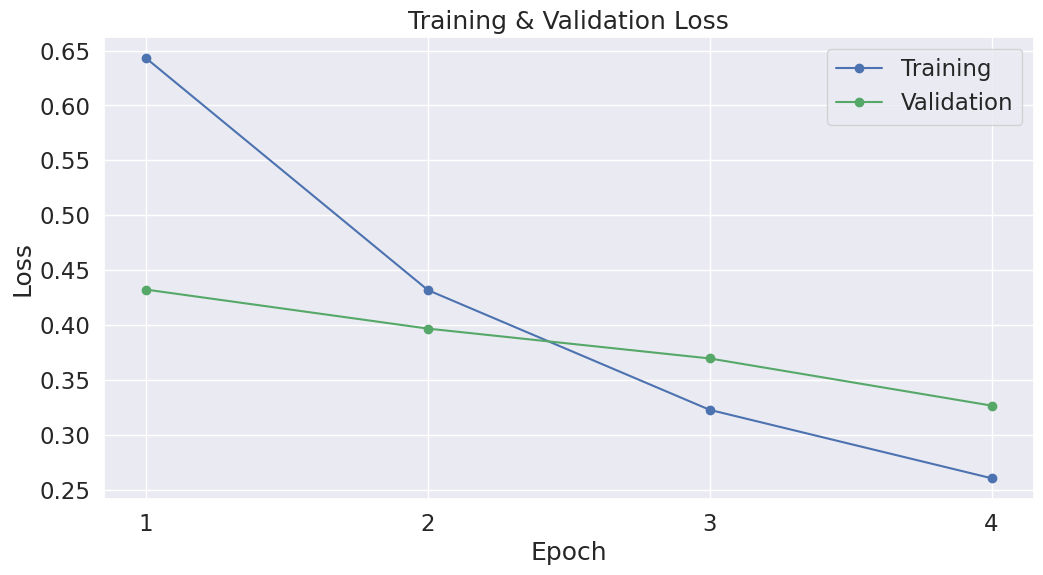

In [ ]:
# Используем стиль графиков из seaborn.
sns.set(style='darkgrid')

# Увеличиваем размер графика и размер шрифта.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Строим кривую обучения.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Подписываем график.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Качество на отложенной выборке. Для оценки качества зафайнтьюненой модели оценим качество на тесте с использованием F1_score.

### 5.1. Подготовка данных



Применим к тестовым данным те же шаги предобработки данных, которые мы применяли для обучающей и валидационной выборкок.

In [ ]:
df = pd.read_csv('drive/MyDrive/test.csv')

In [ ]:
# Выведем чичло наблюдений на тесте.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

Number of test sentences: 25,000



In [ ]:
df.groupby(label_column).count()

,id,text,rating
positive,,,
0,12500,12500,12500
1,12500,12500,12500


In [ ]:
df[label_column]

,positive
0,1
1,1
2,1
3,1
4,1
...,...
24995,0
24996,0
24997,0
24998,0


In [ ]:
texts = df[text_column].astype(str).values
labels = encoder.transform(df[label_column])

In [ ]:
texts[:2]

array(["I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.",
       'Actor turned director Bill Paxton follows up his promising debut, the Gothic-horror "Frailty", with this family friendly sports drama about the 1913 U.S. Open where a young American caddy

In [ ]:
labels

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
# Токенизируем все тексты и сопоставляем токены с их идентификаторами слов.
input_ids, attention_masks, labels = preparing_text_and_labels(texts, labels, max_length, truncation=True) #Truncation for evoiding long cases


In [ ]:
# Создаем DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## 5.2. Оценка на тесте



После того, как мы подготовили тестовые данные, сгенерируем предсказания с использованием дообученной модели.

In [ ]:
# Прогнозирование меток для {:,} тестовых текстов...
def get_predictions(model, prediction_dataloader):
  print('Predicting labels for {:,} test texts...'.format(len(input_ids)))
  # Переводим модель в режим оценки
  model.eval()

  predictions , true_labels = [], []

  # Прогноз
  for batch in prediction_dataloader:
    # Перемещаем батч на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем входные данные из нашего dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Прямой проход, вычисляем логиты предсказаний
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Перемещаем логиты и метки на CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказания и истинные метки
    predictions.append(logits)
    true_labels.append(label_ids)

  print()
  print('DONE.')
  return predictions, true_labels

In [ ]:
predictions, true_labels = get_predictions(model, prediction_dataloader)

Predicting labels for 25,000 test texts...

DONE.


In [ ]:
predictions = encoder.inverse_transform(predictions)

В качестве метрики возьмем accuracy.

In [ ]:
accuracy_set = []

# Оцениваем каждую тестовую партию, используя коэффициент корреляции Мэтьюса
print('Calculating accuracy Score for each batch...')

# Для каждой входной партии...
for i in range(len(true_labels)):

  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Вычисляем и сохраняем коэффициент для этой партии.
  accuracy = accuracy_score(true_labels[i], pred_labels_i)
  accuracy_set.append(accuracy)


Calculating accuracy Score for each batch...


Финальный скор считается по всему датасету, дополнительно посмотрим на скоры на отдельных батчах.


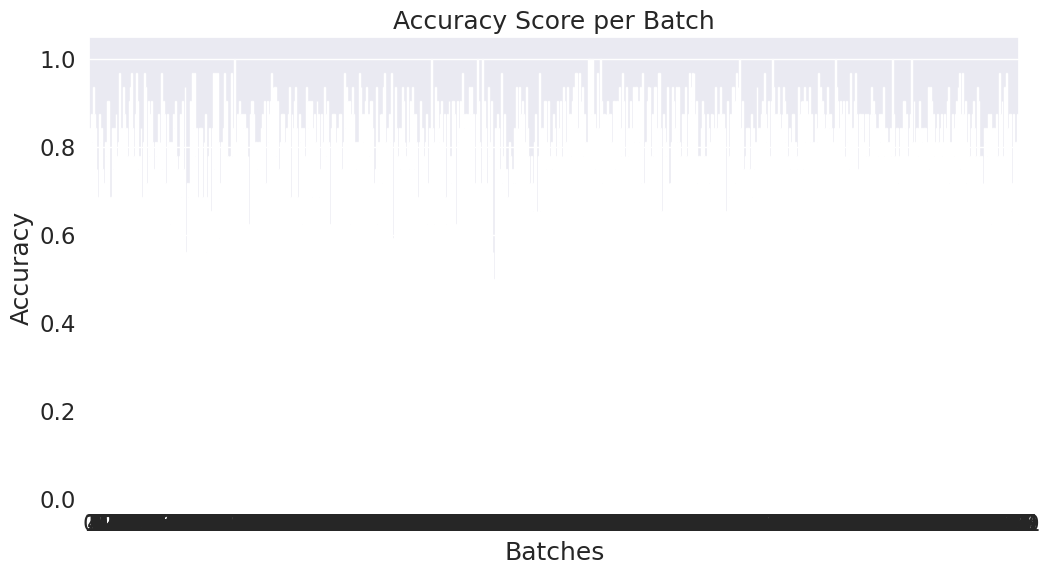

In [ ]:
# Создаем столбчатую диаграмму, которая показывает скор на каждом батче
ax = sns.barplot(x=list(range(len(accuracy_set))), y=accuracy_set, errorbar=None)

plt.title('Accuracy Score per Batch')
plt.ylabel('Accuracy')
plt.xlabel('Batches')

plt.show()

Объединим результаты и получим общий скор.

In [ ]:

def get_results(predictions, true_labels, average='binary'):
    # Объединяем результаты по всем партиям.
    flat_predictions = np.concatenate(predictions, axis=0)

    # Для каждого образца выбираем метку (0 или 1) с более высоким баллом.
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Объединяем правильные метки для каждой партии в один список.
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # Вычисляем F1
    f1 = f1_score(flat_true_labels, flat_predictions, average=average)
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    precision = precision_score(flat_true_labels, flat_predictions, average=average)
    recall = recall_score(flat_true_labels, flat_predictions, average=average)

    print('Total Accuracy: %.3f' % accuracy)
    print('Total Precision: %.3f' % precision)
    print('Total Recall: %.3f' % recall)
    print('Total F1: %.3f' % f1)

In [ ]:
get_results(predictions, true_labels, average='binary')

Total Accuracy: 0.845
Total Precision: 0.854
Total Recall: 0.832
Total F1: 0.843



**Успех!** Спустя небольшое количество времени мы получили хорошую модель с качеством выше чем у моделей, обученных с нуля.



# Заключение

Используя предобученную сеть cointegrated/rubert-tiny2 с помощью простого файн тюнинга удается добиться лучшего качества среди всех моделей. А также модель довольно быстро обучается, что позволит в дальнейшем только улучшать её.

##  Сохранение модели

Код ниже позволяет сохранить дообученную модель и соотвествующий ей токенайзер на диск.

Так как код выполнялся на GPU Google Colab.

In [ ]:
output_dir = './model_save_rating/'

# Создайте выходной каталог, если это необходимо
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Сохраните обученную модель, конфигурацию и токенизатор с помощью save_pretrained().
# Их можно будет загрузить позже с помощью from_pretrained()
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Хорошая практика: сохраняйте ваши аргументы обучения вместе с обученной моделью
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Посмотрим размеры файлов.

In [ ]:
!ls -l --block-size=K ./model_save_rating/

total 427940K
-rw-r--r-- 1 root root      1K Oct 13 06:25 config.json
-rw-r--r-- 1 root root 427694K Oct 13 06:25 model.safetensors
-rw-r--r-- 1 root root      1K Oct 13 06:25 special_tokens_map.json
-rw-r--r-- 1 root root      2K Oct 13 06:25 tokenizer_config.json
-rw-r--r-- 1 root root    227K Oct 13 06:25 vocab.txt


In [ ]:
!ls -l --block-size=M ./model_save_rating/model.safetensors

-rw-r--r-- 1 root root 418M Oct 13 06:25 ./model_save/model.safetensors


Файл весит 418 мб

Код ниже позволяет загрузить сохраненную модель.

In [7]:
# Загрузите обученную модель и словарь, которые вы дообучили
model = BertForSequenceClassification.from_pretrained('../model_save_rating')
tokenizer = BertTokenizer.from_pretrained('../model_save_rating')

# Перенесите модель на GPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [12]:
text1 = "Great. Masterpiece. I think that it\' the best film i\'ve ever seen. " #Должно быть позтивным

text2 = "The worst. I will not recomend this film to anyone. Don't see it" #Должно быть негативом

In [9]:
def get_pred(text, model):
    encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
    model.eval()  # Переключаем модель в режим оценки
    with torch.no_grad():  # Отключаем автоматическое отслеживание градиентов
        output = model(**encoded_input)  # Получаем выходные данные модели

    # Получаем логиты и предсказанный класс
    logits = output.logits
    predicted_class = torch.argmax(logits, dim=-1).item()  # Находим класс с максимальным значением логитов
    return predicted_class

In [10]:
get_pred(text1, model)

1

In [11]:
get_pred(text2, model)

0